# AST 384C - Computational Astrophysics - Final Project
## Carlos Jurado

In [1]:
# Python package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import timeit
from tqdm import tqdm
import time
from scipy.stats import uniform
from numba import njit, prange
import scipy

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

## Problem 1: 

Can LLMs replace you (or at least, your answers to homework problems)?

Using the AI of your choice (e.g. Chat-GPT, Claude, etc.), redo the following problems:

• HW1, problem 2 (generating the positions & velocities), no need to do efficiency tests

• HW2, problem 1 (4th-order RK for Kepler problem) with e =0.96

• Hogg & Foreman-Mackey, problem 2 (M-H algorithm with a Gaussian likelihood)

In each case, describe how easy (or hard) it was to get the LLM to give a solution, whether
the initial solution was right, and discuss how it compares to your solution. Can AI replace
your brain for doing HW? If so, for what kinds of problems?

## Redoing HW1, Problem 1 With ChatGPT

Sampling velocities:   2%|▏         | 159/10000 [00:00<00:18, 523.63it/s]

Particle 0: radius = 174.3801 kpc, potential = -2.0546e+07
Particle 0: sampled energy = -2.7484e+06, max energy = -2.0546e+07


Sampling velocities:  11%|█         | 1060/10000 [00:02<00:16, 527.00it/s]

Particle 1000: radius = 39.7275 kpc, potential = -5.7569e+07
Particle 1000: sampled energy = -1.9308e+07, max energy = -5.7569e+07


Sampling velocities:  21%|██        | 2088/10000 [00:03<00:14, 542.99it/s]

Particle 2000: radius = 41.2621 kpc, potential = -5.6411e+07
Particle 2000: sampled energy = -3.0907e+07, max energy = -5.6411e+07


Sampling velocities:  31%|███       | 3063/10000 [00:05<00:12, 536.73it/s]

Particle 3000: radius = 44.7117 kpc, potential = -5.3970e+07
Particle 3000: sampled energy = -3.4929e+07, max energy = -5.3970e+07


Sampling velocities:  41%|████      | 4090/10000 [00:07<00:11, 535.34it/s]

Particle 4000: radius = 60.2503 kpc, potential = -4.5165e+07
Particle 4000: sampled energy = -1.3548e+07, max energy = -4.5165e+07


Sampling velocities:  51%|█████     | 5066/10000 [00:09<00:09, 538.87it/s]

Particle 5000: radius = 54.0635 kpc, potential = -4.8303e+07
Particle 5000: sampled energy = -4.2613e+06, max energy = -4.8303e+07


Sampling velocities:  62%|██████▏   | 6154/10000 [00:11<00:07, 531.35it/s]

Particle 6000: radius = 55.1870 kpc, potential = -4.7701e+07
Particle 6000: sampled energy = -6.0296e+06, max energy = -4.7701e+07


Sampling velocities:  71%|███████   | 7106/10000 [00:13<00:05, 519.16it/s]

Particle 7000: radius = 41.2470 kpc, potential = -5.6422e+07
Particle 7000: sampled energy = -9.0250e+06, max energy = -5.6422e+07


Sampling velocities:  81%|████████  | 8056/10000 [00:15<00:03, 525.66it/s]

Particle 8000: radius = 48.4360 kpc, potential = -5.1560e+07
Particle 8000: sampled energy = -3.2394e+06, max energy = -5.1560e+07


Sampling velocities:  91%|█████████ | 9075/10000 [00:17<00:01, 530.09it/s]

Particle 9000: radius = 42.2572 kpc, potential = -5.5684e+07
Particle 9000: sampled energy = -4.4078e+07, max energy = -5.5684e+07


Sampling velocities: 100%|██████████| 10000/10000 [00:18<00:00, 527.37it/s]


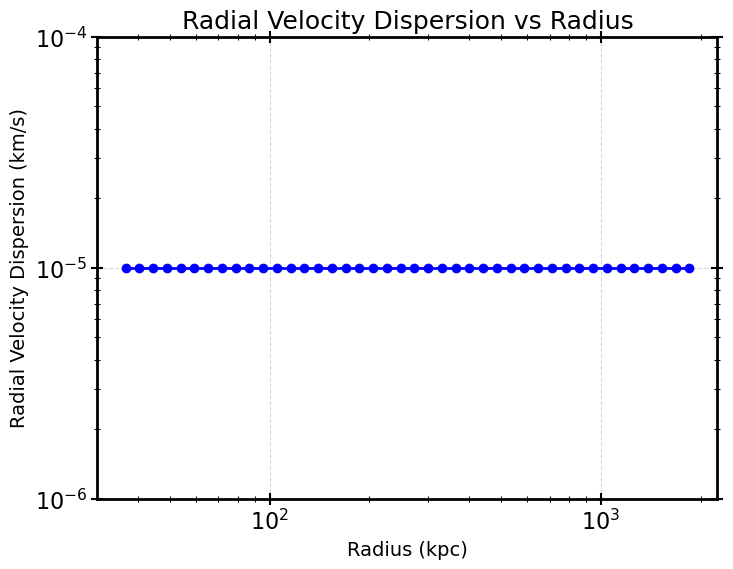

Generated 10000 particles.


In [44]:
# Constants
M = 1e12  # Total mass in solar masses
a = 35  # Scale length in kpc
N = int(1e6)  # Number of particles
G = 4.302e-3  # Gravitational constant in (kpc * M_sun) / (km/s)^2

# Gravitational potential function (Hernquist model)
def potential(r):
    return -G * M / (r + a)

# Energy distribution function (Hernquist 1990, Equation 17)
def energy_distribution(r):
    phi = potential(r)  # Gravitational potential at position r
    def f(E):
        q = np.sqrt(E / phi)  # Energy normalized by potential
        if 0 <= q < 1:
            return (M / (2 * np.pi * a**3)) * (1 - q**2)**(5/2) * (3 * np.arcsin(q) + q * (1 - q**2)**(1/2) * (1 - 2 * q**2))
        return 0
    return f

# Position sampling from Hernquist distribution
def sample_positions(N):
    # Uniform sampling in the radial direction
    r = np.zeros(N)
    for i in range(N):
        u = uniform.rvs()  # Uniform random variable between 0 and 1
        r[i] = a * (1 - u)**(-1/2)  # Sampling positions according to the Hernquist profile
    return r

# Velocity sampling using the acceptance-rejection method
def sample_velocities(r):
    velocities = np.zeros(N)
    min_velocity = 1e-5  # Set a minimum threshold for the velocity (bounding function)

    for i in tqdm(range(N), desc="Sampling velocities"):
        radius = r[i]
        phi = potential(radius)
        
        # Debug: Print the potential for each particle
        if i % 1000 == 0:  # Print every 1000th particle for inspection
            print(f"Particle {i}: radius = {radius:.4f} kpc, potential = {phi:.4e}")
        
        # Define the maximum possible energy
        E_max = phi
        
        # Sample energy using the distribution function f(E) via acceptance-rejection
        energy_distribution_func = energy_distribution(radius)
        energy = E_max * uniform.rvs()
        
        # Debug: Print sampled energy
        if i % 1000 == 0:  # Print every 1000th particle for inspection
            print(f"Particle {i}: sampled energy = {energy:.4e}, max energy = {E_max:.4e}")

        # Rejection sampling loop with added safeguards
        attempts = 0
        while True:
            attempts += 1
            # Check if energy is valid, ensure it's within the correct range
            if attempts > 100:  # Safety to avoid infinite loop
                break
            
            energy = E_max * uniform.rvs()
            
            # If the energy is too large, skip it
            if energy > E_max:
                continue

            energy_val = energy_distribution_func(energy)
            
            # Avoid divide by zero or very small values
            if energy_val < 1e-10:
                continue
            
            # Acceptance-rejection step
            if uniform.rvs() < energy_val / energy_distribution_func(E_max):
                break

        # Convert energy to velocity, ensuring no negative values inside sqrt
        if phi - energy >= 0:
            velocity = np.sqrt(2 * (phi - energy))  # Using E = phi - v^2 / 2, solve for v
            velocities[i] = max(velocity, min_velocity)  # Apply the bounding function
        else:
            velocities[i] = min_velocity  # Set to the minimum velocity if energy is invalid

    return velocities

# Main function to generate particles' positions and velocities
def generate_particles(N):
    positions = sample_positions(N)
    velocities = sample_velocities(positions)
    
    # Check if any NaN values exist in velocities
    if np.any(np.isnan(velocities)):
        print("Error: NaN values detected in velocities.")
        return None, None

    # Compute radial velocities (assuming isotropy, v_r = v)
    radial_velocities = velocities  # Assuming isotropy, radial component is the full velocity

    # Compute radial velocity dispersion as a function of radius
    bins = np.logspace(np.log10(min(positions)), np.log10(max(positions)), 50)  # Logarithmic bins for radius
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Compute bin centers
    velocity_dispersion = []

    for i in range(1, len(bins)):
        # Select particles within the current bin
        mask = (positions >= bins[i-1]) & (positions < bins[i])
        if np.sum(mask) > 0:
            # Compute the radial velocity dispersion for the selected particles
            vr = radial_velocities[mask]
            dispersion = np.sqrt(np.mean(vr**2))
            velocity_dispersion.append(dispersion)

    # Remove any bins that did not have any particles (empty bins)
    velocity_dispersion = np.array(velocity_dispersion)
    bin_centers = bin_centers[:len(velocity_dispersion)]

    # Avoid log scale errors by setting small values to a small positive number
    velocity_dispersion = np.maximum(velocity_dispersion, 1e-10)

    # Plot the radial velocity dispersion as a function of radius
    plt.plot(bin_centers, velocity_dispersion, marker='o', linestyle='-', color='b')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Radial Velocity Dispersion (km/s)')
    plt.title('Radial Velocity Dispersion vs Radius')
    plt.grid(True)
    plt.show()

    return positions, velocities

# Generate positions and velocities
positions, velocities = generate_particles(N)

if positions is not None and velocities is not None:
    print(f"Generated {N} particles.")


#### I start the ChatGPT prompt by asking it to write me a functional python code with thorough usage of comments that answers the prompt. I then paste the homework prompt. 

#### The code that ChatGPT produces is shown above. As is seen, ChatGPT is unable to reproduce the correct radial velocity disperion as a function of radius plot. I spent around 30-45 minutes asking ChatGPT to fix some of the code errors that were produced, such as unequal sized arrays. The reason why the radial velocity dispersion is a flat horizontal line is because I also asked ChatGPT to ensure that if there are any energy values that are zero or negative, to set to 10^-5. Upon further inspecting the code it seems to be the case that energy values are being sampled from the functional form of the energy distribution function. 

#### I thus write the following chatgpt response: "In this current code, you am sampling a value from the energy function but over many iterations that won't necessarily produce the distribution of energies according to the density function. Instead, you should write code that samples a uniform value from the CDF and then inverts the CDF to get the associated energy. It looks like the energy distribution function has a complex form and it may be neccessary to use a function that approximates the energy distribution function and invert that. You can then use acception-rejection sampling to eventually ensure that only values within the range of the energy distribution function are accepted. Can you write me code that implements these changes?"

#### The code below is where ChatGPT tries to numerically invert the CDF, rather than use a bounding function. Even in this case, ChatGPT is unable to reproduce the correct radial velocity dispersion plot. This highlights the point that ChatGPT is currently lacking in writing code that requires some level of creativity. My solution was to use a power law bounding function that scaled as sqrt(r) in order for the bounding functiont to always approximate to the energy distribution function for a particle at a given radius because the max energy changes depending on the value of r the particle is located at. I'd say in this case, AI is struggling with the domain knoweldge when trying to create code that solves this problem. Because each particle at a given radius, has a differnt max energy it can obtain, it changes the distribution of the CDF for each radius and this is something ChatGPT is overlooking. I could tell ChatGPT more explicity what the issue in the code is but at that point it seems to be more user-input that AI driven code. 

Sampling velocities: 100%|██████████| 10000/10000 [00:22<00:00, 453.49it/s]


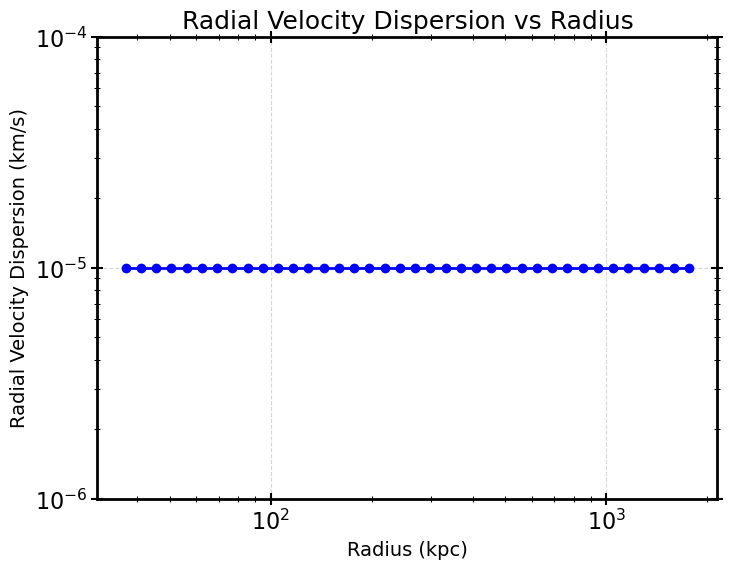

Generated 10000 particles.


In [3]:
# Constants
M = 1e12  # Total mass in solar masses
a = 35  # Scale length in kpc
N = int(1e4)  # Number of particles
G = 4.302e-3  # Gravitational constant in (kpc * M_sun) / (km/s)^2

# Gravitational potential function (Hernquist model)
def potential(r):
    return -G * M / (r + a)

# Energy distribution function (Hernquist 1990, Equation 17)
def energy_distribution(r):
    phi = potential(r)  # Gravitational potential at position r
    def f(E):
        q = np.sqrt(E / phi)  # Energy normalized by potential
        if 0 <= q < 1:
            return (M / (2 * np.pi * a**3)) * (1 - q**2)**(5/2) * (3 * np.arcsin(q) + q * (1 - q**2)**(1/2) * (1 - 2 * q**2))
        return 0
    return f

# Numerically integrate the energy distribution function to compute the CDF
def compute_cdf(r, num_points=1000):
    # Define energy range from 0 to the maximum energy at the given radius
    E_max = potential(r)
    energy_values = np.linspace(0, E_max, num_points)
    
    # Get the corresponding values of the energy distribution function
    f_values = np.array([energy_distribution(r)(E) for E in energy_values])
    
    # Normalize the energy distribution to get the CDF
    cdf_values = np.cumsum(f_values) * (energy_values[1] - energy_values[0])  # Numerical integration
    cdf_values /= cdf_values[-1]  # Normalize so the CDF goes from 0 to 1
    
    return energy_values, cdf_values

# Inverse CDF sampling: Sample energy by inverting the CDF
def sample_energy(r):
    energy_values, cdf_values = compute_cdf(r)
    
    # Sample a uniform random value between 0 and 1
    u = uniform.rvs()
    
    # Use inverse transform sampling to find the corresponding energy
    energy = np.interp(u, cdf_values, energy_values)
    
    return energy

# Position sampling from Hernquist distribution
def sample_positions(N):
    r = np.zeros(N)
    for i in range(N):
        u = uniform.rvs()  # Uniform random variable between 0 and 1
        r[i] = a * (1 - u)**(-1/2)  # Sampling positions according to the Hernquist profile
    return r

# Velocity sampling using inverse CDF and acceptance-rejection method
def sample_velocities(r):
    velocities = np.zeros(N)
    min_velocity = 1e-5  # Set a minimum threshold for the velocity

    for i in tqdm(range(N), desc="Sampling velocities"):
        radius = r[i]
        phi = potential(radius)
        
        # Sample energy using the inverse CDF
        energy = sample_energy(radius)
        
        # Ensure the energy is within the valid range
        if phi - energy >= 0:
            velocity = np.sqrt(2 * (phi - energy))  # Using E = phi - v^2 / 2, solve for v
            velocities[i] = max(velocity, min_velocity)  # Apply the bounding function
        else:
            velocities[i] = min_velocity  # Set to the minimum velocity if energy is invalid

    return velocities

# Main function to generate particles' positions and velocities
def generate_particles(N):
    positions = sample_positions(N)
    velocities = sample_velocities(positions)
    
    # Check if any NaN values exist in velocities
    if np.any(np.isnan(velocities)):
        print("Error: NaN values detected in velocities.")
        return None, None

    # Compute radial velocities (assuming isotropy, v_r = v)
    radial_velocities = velocities  # Assuming isotropy, radial component is the full velocity

    # Compute radial velocity dispersion as a function of radius
    bins = np.logspace(np.log10(min(positions)), np.log10(max(positions)), 50)  # Logarithmic bins for radius
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Compute bin centers
    velocity_dispersion = []

    for i in range(1, len(bins)):
        # Select particles within the current bin
        mask = (positions >= bins[i-1]) & (positions < bins[i])
        if np.sum(mask) > 0:
            # Compute the radial velocity dispersion for the selected particles
            vr = radial_velocities[mask]
            dispersion = np.sqrt(np.mean(vr**2))
            velocity_dispersion.append(dispersion)

    # Remove any bins that did not have any particles (empty bins)
    velocity_dispersion = np.array(velocity_dispersion)
    bin_centers = bin_centers[:len(velocity_dispersion)]

    # Avoid log scale errors by setting small values to a small positive number
    velocity_dispersion = np.maximum(velocity_dispersion, 1e-10)

    # Plot the radial velocity dispersion as a function of radius
    plt.plot(bin_centers, velocity_dispersion, marker='o', linestyle='-', color='b')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Radial Velocity Dispersion (km/s)')
    plt.title('Radial Velocity Dispersion vs Radius')
    plt.grid(True)
    plt.show()

    return positions, velocities

# Generate positions and velocities
positions, velocities = generate_particles(N)

if positions is not None and velocities is not None:
    print(f"Generated {N} particles.")


## Redoing HW2, Problem 1 With ChatGPT

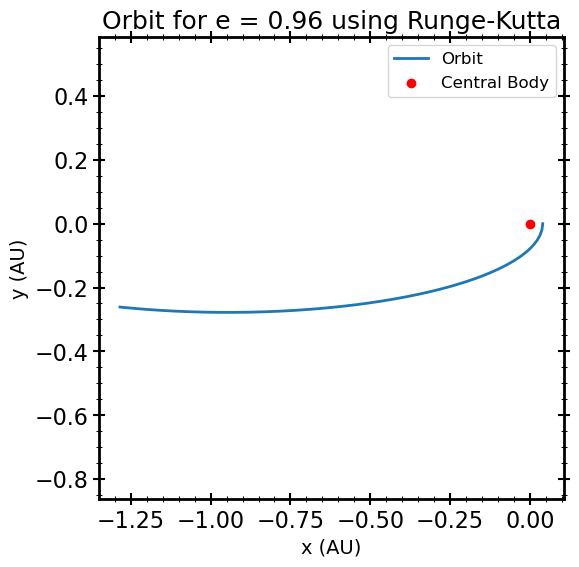

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 1.0  # Gravitational constant, normalized for solar mass and AU
M = 1.0  # Mass of the central body (1 M⊙)
a = 1.0  # Semi-major axis in AU
e = 0.96  # Eccentricity

# Calculate rp and vp from the given equations
rp = a * (1 - e)  # Pericenter distance
vp = np.sqrt(G * M / a * (1 + e) / (1 - e))  # Pericenter velocity

# Initial conditions
r0 = np.array([rp, 0])  # Position at pericenter (x, y)
v0 = np.array([0, -vp])  # Velocity at pericenter (vx, vy)
y0 = np.concatenate((r0, v0))  # Initial state [x, y, vx, vy]

# Time parameters
T = 1  # Period in years (for a circular orbit, period is 2π for this system)
num_steps = 365  # Number of steps (1 step per day for 1 year)
dt = T / num_steps  # Time step (1 day)
t_values = np.linspace(0, T, num_steps)

# Define the system of equations: r_dot = v, v_dot = -GM / r^3 * r
def kepler_rhs(t, y):
    r = y[:2]
    v = y[2:]
    r_mag = np.linalg.norm(r)
    
    # Acceleration due to gravity
    a = -G * M / r_mag**3 * r
    
    return np.concatenate((v, a))

# 4th-order Runge-Kutta solver
def runge_kutta_4th_order(f, y0, t0, tf, dt):
    times = np.arange(t0, tf, dt)
    y = np.zeros((len(times), len(y0)))
    y[0] = y0
    
    for i in range(1, len(times)):
        t = times[i-1]
        y_current = y[i-1]
        
        k1 = f(t, y_current)
        k2 = f(t + dt/2, y_current + dt/2 * k1)
        k3 = f(t + dt/2, y_current + dt/2 * k2)
        k4 = f(t + dt, y_current + dt * k3)
        
        y[i] = y_current + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return times, y

# Solve the system using Runge-Kutta
times, solution = runge_kutta_4th_order(kepler_rhs, y0, 0, T, dt)

# Extract position and velocity
positions = solution[:, :2]
velocities = solution[:, 2:]

# Plot the orbit
plt.figure(figsize=(6, 6))
plt.plot(positions[:, 0], positions[:, 1], label='Orbit')
plt.scatter([0], [0], color='red', label='Central Body')
plt.title("Orbit for e = 0.96 using Runge-Kutta")
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.axis('equal')
plt.legend()
plt.show()


#### I start the ChatGPT prompt by asking it to write me a functional python code with thorough usage of comments that answers the prompt. I then paste the homework prompt. 

#### The code that ChatGPT produces is shown above. As is seen, ChatGPT decided to write the code without any adaptive timestepping and the result it gets is the same that I do without adaptive timestepping. When I ask ChatGPT to incorporate adaptive timestepping into it's code, it is unable to create code that does not generate errors. I spent about 30 minutes trying to debug the code with ChatGPT, without showing it my code, and it did not seem to fix the error. Instead, ChatGPT begins to get stuck in a logic loop and repeats it's same code after a few iterations. I am suprised by this result, because the critera for adaptive timestepping was laid out in the HW prompt and should have been fairly straightforward for ChatGPT to implement. It shouldn't have required any creativity like the Hernquist profile problem does. 

## Redoing Hogg & Foreman-Mackey, problem 2 (M-H algorithm with a Gaussian likelihood) With ChatGPT

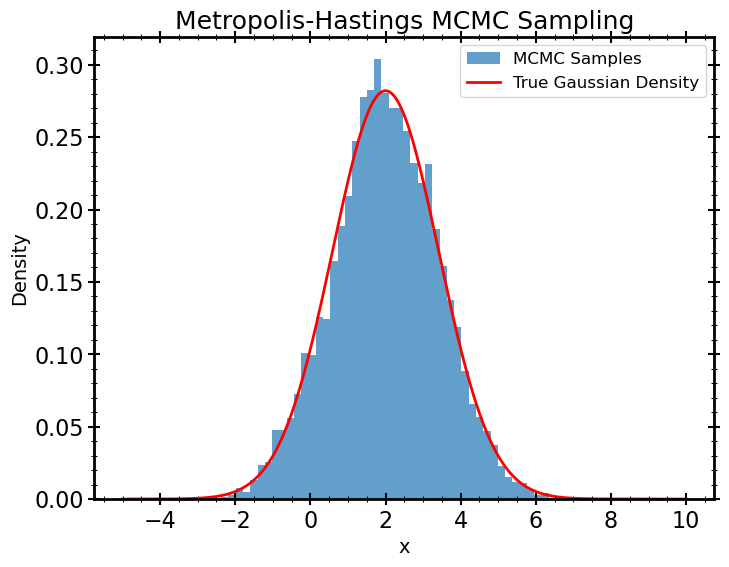

In [ ]:
# Define the target density function p(x), which is a Gaussian with mean 2 and variance 2
def target_density(x, mean=2, variance=2):
    """
    Calculates the probability density of a Gaussian distribution.
    :param x: The point at which to evaluate the density.
    :param mean: The mean of the Gaussian distribution (default is 2).
    :param variance: The variance of the Gaussian distribution (default is 2).
    :return: The probability density of x.
    """
    return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * ((x - mean) ** 2) / variance)

# Define the proposal distribution q(x'|x), which is a Gaussian centered at x with variance 1
def proposal_distribution(x, proposal_variance=1):
    """
    Generates a proposal value x' from a Gaussian distribution with mean x and variance 1.
    :param x: The current value of x.
    :param proposal_variance: The variance of the proposal distribution (default is 1).
    :return: A proposed new value x'.
    """
    return np.random.normal(x, np.sqrt(proposal_variance))

# Metropolis-Hastings MCMC Sampler
def metropolis_hastings_sampler(n_steps, initial_x=0, proposal_variance=1, target_mean=2, target_variance=2):
    """
    Runs the Metropolis-Hastings MCMC sampler to sample from a Gaussian distribution.
    :param n_steps: The number of steps to run the sampler.
    :param initial_x: The initial value of x for the sampler (default is 0).
    :param proposal_variance: The variance of the proposal distribution (default is 1).
    :param target_mean: The mean of the target Gaussian distribution (default is 2).
    :param target_variance: The variance of the target Gaussian distribution (default is 2).
    :return: An array of sampled values.
    """
    # Initialize the array to store samples
    samples = np.zeros(n_steps)
    # Set the initial sample
    samples[0] = initial_x

    for i in range(1, n_steps):
        # Propose a new value using the proposal distribution
        proposed_x = proposal_distribution(samples[i - 1], proposal_variance)
        
        # Calculate the acceptance ratio
        acceptance_ratio = target_density(proposed_x, target_mean, target_variance) / target_density(samples[i - 1], target_mean, target_variance)
        
        # Accept or reject the proposal based on the acceptance ratio
        if np.random.uniform(0, 1) < acceptance_ratio:
            samples[i] = proposed_x  # Accept the proposed value
        else:
            samples[i] = samples[i - 1]  # Reject the proposal and keep the current value

    return samples

# Set up the sampler parameters
n_steps = 10000  # Number of MCMC steps
initial_x = 0    # Initial value of x

# Run the MCMC sampler
samples = metropolis_hastings_sampler(n_steps, initial_x)

# Plot the histogram of the samples
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=50, density=True, alpha=0.7, label='MCMC Samples')

# Plot the true target Gaussian density over the histogram
x_vals = np.linspace(-5, 10, 1000)
true_density = target_density(x_vals)
plt.plot(x_vals, true_density, label='True Gaussian Density', color='red', linewidth=2)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings MCMC Sampling')
plt.legend()
plt.show()


#### I start the ChatGPT prompt by asking it to write me a functional python code with thorough usage of comments that answers the prompt. I then paste the homework prompt. 

#### The first result that ChatGPT produced was pasted into the cell above and as is shown, it accurately performs the metroplis-hastings mcmc sampling for a gaussian distribution. Their code has a simialar structure to mine and I believe this is because the set-up for an mcmc sampler is very simple and routine. This is typically where ChatGPT excels at because  metroplis-hastings mcmc sampling is just an algorithm. ChatGPT struggles to produce useable code for HW 1, Problem 2 because this problem requires some level of creativity. To efficently solve the Hernquist problem, it required that I chose a bounding function that nearly approximates P(E|R) or else too many energies are rejected during the acceptance-rejection criteria, dragging the computational time. Thus, for simple coding task, AI may be able to replace the work of a graduate student. 

## Problem 2

Revisiting the gravity calculation (Do not use LLMs for this problem.)
In HW 3, you used brute force or kd-trees to compute the gravitational force for a random
set of 3D postions assuming vacuum boundary conditions. Redo the brute force version
problem for N = 10^5 but now assume periodic boundary conditions, i.e., the box wraps
around such that coordinate xi = 100 is equivalent to xi = 0. What changes about your
calculation? How does the timing change? How would you use do this with a KDTree (just
sketch out some ideas, no need to go into great detail.

In [56]:
N_arr = [10**5]
time_direct_arr = []
time_KD_arr = []

@njit(parallel=True)
def compute_accelerations(r_vecs, indices=None, distances=None):
    ''' 
    Computes the acceleration of all particles due to the gravitational force from every other particle in the simulation. 
    The acceleration is computed for the direct method. 

    Parameters:
    r_vecs: Numpy array (N, 3) containing the position vector of all particles 
    indices: (For KD Tree Impementation) Index of a particle. In this context, this is an array of the indices for the nearest neighbors to the given particle 
    distances: (For KD Tree Impementation)
    '''
    N = r_vecs.shape[0]
    acc = np.zeros((N, 3))
    
    #Direct Method calculation of the accelerations
    if indices is None:
        for i in prange(N): #loop through each particle
            for j in range(N): #loop through each interaction acting on a given particle
                if i != j: #avoid self-interaction
                    dx = r_vecs[j, 0] - r_vecs[i, 0] #calculate displacement in x-direction
                    dy = r_vecs[j, 1] - r_vecs[i, 1] #calculate displacement in y-direction
                    dz = r_vecs[j, 2] - r_vecs[i, 2] #calculate displacement in z-direction
                    squared_distance = dx*dx + dy*dy + dz*dz  #compute the distance
                    Fg = 1.0 / ((squared_distance)**3 + 1e-6) #calculate the gravitational force
                    acc[i, 0] += dx * Fg #multiply x-acceleration by the x-vector component 
                    acc[i, 1] += dy * Fg #multiply y-acceleration by the y-vector component 
                    acc[i, 2] += dz * Fg #multiply z-acceleration by the z-vector component 
    return acc



def compute_accelerations_ball(r_vecs, neighbors_list):
    N = r_vecs.shape[0]
    acc = np.zeros((N, 3))
    for i in range(N):
        for j in neighbors_list[i]:
            if i != j:
                dx = r_vecs[j, 0] - r_vecs[i, 0]
                dy = r_vecs[j, 1] - r_vecs[i, 1]
                dz = r_vecs[j, 2] - r_vecs[i, 2]
                squared_distance = dx*dx + dy*dy + dz*dz
                Fg = 1.0 / ((squared_distance)**1.5 + 1e-6)
                acc[i, 0] += dx * Fg
                acc[i, 1] += dy * Fg
                acc[i, 2] += dz * Fg
    return acc


for N in N_arr: #loop through simulations with different number of particles
    print(f"\nN = {N}")
    
    # Direct Method
    r_vecs = np.random.uniform(0, 100, size=(N, 3)) #generate uniform random distribution of particles in 3D space
    
    start_time = time.time() #begin tracking time
    acceleration_vecs = compute_accelerations(r_vecs) #calculate the accelerations
    end_time = time.time()
    
    elapsed_time = np.round(end_time - start_time, 2)
    time_direct_arr.append(elapsed_time)
    print(f"Direct: Time taken for {N} particles: {elapsed_time} s")


N = 100000
Direct: Time taken for 100000 particles: 6.7 s
